![Screenshot from my Kaggle profile](titanic_screenshot_from_kaggle.jpg)

# Overview

My secret sauce to a top score in the Titanic competition: integrating numerous new tools and items of knowledge that I have obtained recently.

### The secret sauce is:

1. **Extensive feature engineering,** including target encoding, frequency encoding, regular expression, and more.

2. **Factor analysis and quantile transformation** of the numerical variables.

3. **Feature selection with Boruta Shap.**

4. **Handling the imbalanced dataset using SMOTE.**

5. **Utilizing Keras Classifier and tuning it with Keras tuner.** Yep, DNN rocks on tabular data.

In [1]:
#Load important packages

import numpy as np 
import pandas as pd
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder

from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FactorAnalysis

import re

import matplotlib.pyplot as plt

In [2]:
#Load the data

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Correct the type of the following columns
for col in ['Sex', 'Cabin', 'Ticket', 'Embarked']:
    train[col] = train[col].astype('category')
    test[col] = test[col].astype('category')

#Extract the target
target = train['Survived']

#Combine the train and test for easier EDA and feature eng'
combined = pd.concat([train, test])

#Check the shapes of the dataframes
print('train shape:',train.shape, '\ntest shape:', test.shape, '\ncombined shape:', combined.shape, 
      '\n**************************')

combined.head()

train shape: (891, 12) 
test shape: (418, 11) 
combined shape: (1309, 12) 
**************************


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
%%capture

#Install category_encoders for target encoding
!pip install category_encoders

In [4]:
#Target encode the following features

from category_encoders import TargetEncoder
encoder = TargetEncoder()

combined['Sex_TE'] = encoder.fit_transform(combined.iloc[:891].Sex, target)
combined['Cabin_TE'] = encoder.fit_transform(combined.iloc[:891].Cabin, target)
combined['Ticket_TE'] = encoder.fit_transform(combined.iloc[:891].Ticket, target)
combined['Embarked_TE'] = encoder.fit_transform(combined.iloc[:891].Embarked, target)

In [5]:
#Transform the Sex column to numerical
combined['Sex'] = combined['Sex'].map({'male': 0, 'female': 1})
combined['Sex'] = combined['Sex'].astype(int)

#Extract Titles
combined['Title'] = combined['Name']
combined['Title'] = combined['Name'].str.extract('([A-Za-z]+)\.', expand=True)

#Replace rare titles 
mapping = {'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs', 'Major': 'Other', 
           'Col': 'Other', 'Dr' : 'Other', 'Rev' : 'Other', 'Capt': 'Other', 
           'Jonkheer': 'Royal', 'Sir': 'Royal', 'Lady': 'Royal', 
           'Don': 'Royal', 'Countess': 'Royal', 'Dona': 'Royal'}
           
combined.replace({'Title': mapping}, inplace=True)

#Target encoding the Title
combined['Title_for_te'] = combined['Title'].astype('category')
combined['Title_TE'] = encoder.fit_transform(combined.iloc[:891].Title_for_te, target)
combined.drop(columns=['Title_for_te'], inplace=True)

#Create new feature - is married
combined['Is_Married'] = 0
combined['Is_Married'].loc[combined['Title'] == 'Mrs'] = 1

#Create a new feature of Name Length - because longer names usually are given to higher class people
combined["Name_Length"] = combined.Name.str.replace("[^a-zA-Z]", "").str.len()

#Label encode the Title column
title_dict = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Other': 4, 'Royal': 5, 'Master': 6}
combined['Title'] = combined['Title'].map(title_dict).astype('int')

#Create a feature of Family size
combined['Family_Size'] = combined['Parch'] + combined['SibSp'] + 1

#Create a feature of Family size category
combined['Fsize_Cat'] = combined['Family_Size'].map(lambda val: 'Alone' if val <= 1 else ('Small' if val < 5 else 'Big'))
Fsize_dict = {'Alone':3, 'Small':2, 'Big':1}
combined['Fsize_Cat'] = combined['Fsize_Cat'].map(Fsize_dict).astype('int')

#Extract the Surname
combined['Surname'] = combined['Name'].str.extract('([A-Za-z]+.[A-Za-z]+)\,', expand=True)

#Create a family survival rate feature
MEAN_SURVIVAL_RATE = round(np.mean(train['Survived']), 4)

combined['Family_Friends_Surv_Rate'] = MEAN_SURVIVAL_RATE
combined['Surv_Rate_Invalid'] = 1

for _, grp_df in combined[['Survived', 'Surname', 'Fare', 'Ticket', 'PassengerId']].groupby(['Surname', 'Fare']):                       
    if (len(grp_df) > 1):
        if(grp_df['Survived'].isnull().sum() != len(grp_df)):
            for ind, row in grp_df.iterrows():
                combined.loc[combined['PassengerId'] == row['PassengerId'],
                            'Family_Friends_Surv_Rate'] = round(grp_df['Survived'].mean(), 4)
                combined.loc[combined['PassengerId'] == row['PassengerId'],
                            'Surv_Rate_Invalid'] = 0

for _, grp_df in combined[['Survived', 'Surname', 'Fare', 'Ticket', 'PassengerId', 'Family_Friends_Surv_Rate']].groupby('Ticket'):
    if (len(grp_df) > 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Friends_Surv_Rate'] == 0.) | (row['Family_Friends_Surv_Rate'] == MEAN_SURVIVAL_RATE):
                if(grp_df['Survived'].isnull().sum() != len(grp_df)):
                    combined.loc[combined['PassengerId'] == row['PassengerId'],
                                'Family_Friends_Surv_Rate'] = round(grp_df['Survived'].mean(), 4)
                    combined.loc[combined['PassengerId'] == row['PassengerId'],
                                'Surv_Rate_Invalid'] = 0
                    

#Clean the Cabin column
combined['Cabin'] = combined['Cabin'].astype('category')
combined['Cabin'] = combined['Cabin'].cat.add_categories('U')
combined['Cabin_Clean'] = combined['Cabin'].fillna('U')
combined['Cabin_Clean'] = combined['Cabin_Clean'].str.strip(' ').str[0]

# Label Encoding of the Cabin
cabin_dict = {'A':9, 'B':8, 'C':7, 'D':6, 'E':5, 'F':4, 'G':3, 'T':2, 'U':1}
combined['Cabin_Clean'] = combined['Cabin_Clean'].map(cabin_dict).astype('int')

#Target encoding of the Cleaned cabin column
combined['Cabin_for_te'] = combined['Cabin_Clean'].astype('category')
combined['Cabin_TE'] = encoder.fit_transform(combined.iloc[:891].Cabin_for_te, target)
combined.drop(columns=['Cabin_for_te'], inplace=True)

#Clean the ticket column
def clean_ticket(each_ticket):
    prefix = re.sub(r'[^a-zA-Z]', '', each_ticket)
    if(prefix):
        return prefix
    else:
        return "NUM"

combined["Tkt_Clean"] = combined.Ticket.apply(clean_ticket)

#Create ticket frequency column
combined['Ticket_Frequency'] = combined.groupby('Ticket')['Ticket'].transform('count')

#Create ticket groups
Ticket_Count = dict(combined['Ticket'].value_counts())
combined['TicketGroup'] = combined['Ticket'].map(Ticket_Count)

def Ticket_Label(s):
    if (s >= 2) & (s <= 4):
        return 2
    elif ((s > 4) & (s <= 8)) | (s == 1):
        return 1
    elif (s > 8):
        return 0

combined['TicketGroup'] = combined['TicketGroup'].apply(Ticket_Label)


#Create fare bins
def fare_cat(fare):
    if fare <= 7.0:
        return 1
    elif fare <= 39 and fare > 7.0:
        return 2
    else:
        return 3

combined.loc[:, 'Fare_Cat'] = combined['Fare'].apply(fare_cat).astype('int')

#Create some more columns with mult and div (to help the model)
combined.loc[:, 'Fare_Family_Size'] = combined['Fare']/combined['Family_Size']
combined.loc[:, 'Fare_Cat_Pclass'] = combined['Fare_Cat']*combined['Pclass']
combined.loc[:, 'Fare_Cat_Title'] = combined['Fare_Cat']*combined['Title']
combined.loc[:, 'Fsize_Cat_Title'] = combined['Fsize_Cat']*combined['Title']
combined.loc[:, 'Fsize_Cat_Fare_Cat'] = combined['Fare_Cat']/combined['Fsize_Cat'].astype('int')
combined.loc[:, 'Pclass_Title'] = combined['Pclass']*combined['Title']
combined.loc[:, 'Fsize_Cat_Pclass'] = combined['Fsize_Cat']*combined['Pclass']
combined['surv_rate_div_title'] = combined['Family_Friends_Surv_Rate'] / combined['Title']

#Create bins of the Cabin number where available
combined['Cabin_num'] = combined['Cabin'].map(lambda x: re.sub("\D", "", x))
combined['Cabin_num'] = pd.to_numeric(combined['Cabin_num'])
combined['Cabin_num_bins'] = pd.qcut(combined['Cabin_num'], 10, labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
combined['Cabin_num_bins'] = combined['Cabin_num_bins'].cat.add_categories(0)
combined['Cabin_num_bins'] = combined['Cabin_num_bins'].fillna(0)
combined['Cabin_num_bins'] = combined['Cabin_num_bins'].astype(int)

#Create bins of the Ticket number where available
combined['Ticket_num'] = combined['Ticket'].map(lambda x: re.sub("\D", "", x))
combined['Ticket_num'] = pd.to_numeric(combined['Ticket_num'])
combined['Ticket_num_bins'] = pd.qcut(combined['Ticket_num'], 10, labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
combined['Ticket_num_bins'] = combined['Ticket_num_bins'].cat.add_categories(0)
combined['Ticket_num_bins'] = combined['Ticket_num_bins'].fillna(0)
combined['Ticket_num_bins'] = combined['Ticket_num_bins'].astype(int)

#Create some more columns with mult and div (to help the model)
combined.loc[:, 'Fare_Family_Size'] = combined['Fare']/combined['Family_Size']
combined.loc[:, 'Fare_Cat_Pclass'] = combined['Fare_Cat']*combined['Pclass']
combined.loc[:, 'Fare_Cat_Title'] = combined['Fare_Cat']*combined['Title']
combined.loc[:, 'Fsize_Cat_Title'] = combined['Fsize_Cat']*combined['Title']
combined.loc[:, 'Fsize_Cat_Fare_Cat'] = combined['Fare_Cat']/combined['Fsize_Cat'].astype('int')
combined.loc[:, 'Pclass_Title'] = combined['Pclass']*combined['Title']
combined.loc[:, 'Fsize_Cat_Pclass'] = combined['Fsize_Cat']*combined['Pclass']

combined['Cabin_num_bins_mult_Fsize_Cat'] = combined['Cabin_num_bins'] * combined['Fsize_Cat']
combined['Cabin_num_bins_mult_Title'] = combined['Cabin_num_bins'] * combined['Title']
combined['Cabin_num_bins_mult_Pclass'] = combined['Cabin_num_bins'] * combined['Pclass']
combined['Cabin_num_bins_mult_Family_Friends_Surv_Rate'] = combined['Cabin_num_bins'] * combined['Family_Friends_Surv_Rate']
combined['Cabin_num_bins_mult_Fare'] = combined['Cabin_num_bins'] * combined['Fare']
combined['Cabin_num_bins_mult_Ticket_num_bins'] = combined['Cabin_num_bins'] * combined['Ticket_num_bins']

combined['Ticket_num_bins_mult_Fsize_Cat'] = combined['Ticket_num_bins'] * combined['Fsize_Cat']
combined['Ticket_num_bins_mult_Title'] = combined['Ticket_num_bins'] * combined['Title']
combined['Ticket_num_bins_mult_Pclass'] = combined['Ticket_num_bins'] * combined['Pclass']
combined['Ticket_num_bins_mult_Family_Friends_Surv_Rate'] = combined['Ticket_num_bins'] * combined['Family_Friends_Surv_Rate']
combined['Ticket_num_bins_mult_Fare'] = combined['Ticket_num_bins'] * combined['Fare']

#Frequencies encodings
feature_counts = combined.groupby('Pclass').size()
combined['Pclass_frqeuency_encoding'] = combined['Pclass'].apply(lambda x:feature_counts[x])

title_counts = combined.groupby('Title').size()
combined['Title_frqeuency_encoding'] = combined['Title'].apply(lambda x:title_counts[x])

Fsize_Cat_counts = combined.groupby('Fsize_Cat').size()
combined['Fsize_Cat_frqeuency_encoding'] = combined['Fsize_Cat'].apply(lambda x:Fsize_Cat_counts[x])

Family_Friends_Surv_Rate_counts = combined.groupby('Family_Friends_Surv_Rate').size()
combined['Family_Friends_Surv_Rate_frqeuency_encoding'] = combined['Family_Friends_Surv_Rate'].apply(lambda x:Family_Friends_Surv_Rate_counts[x])

Cabin_Clean_counts = combined.groupby('Cabin_Clean').size()
combined['Cabin_Clean_frqeuency_encoding'] = combined['Cabin_Clean'].apply(lambda x:Cabin_Clean_counts[x])

TicketGroup_counts = combined.groupby('TicketGroup').size()
combined['TicketGroup_frqeuency_encoding'] = combined['TicketGroup'].apply(lambda x:TicketGroup_counts[x])

Fare_Cat_counts = combined.groupby('Fare_Cat').size()
combined['Fare_Cat_frqeuency_encoding'] = combined['Fare_Cat'].apply(lambda x:Fare_Cat_counts[x])

Cabin_num_bins_counts = combined.groupby('Cabin_num_bins').size()
combined['Cabin_num_bins_frqeuency_encoding'] = combined['Cabin_num_bins'].apply(lambda x:Cabin_num_bins_counts[x])

Ticket_num_bins_counts = combined.groupby('Ticket_num_bins').size()
combined['Ticket_num_bins_frqeuency_encoding'] = combined['Ticket_num_bins'].apply(lambda x:Ticket_num_bins_counts[x])

Pclass_and_Title_counts = combined.groupby(['Pclass', 'Title']).size()
combined['Pclass_and_Title_frqeuency_encoding'] = combined[['Pclass', 'Title']].apply(lambda x:Pclass_and_Title_counts[x[0]][x[1]], axis=1)

Pclass_and_Fsize_Cat_counts = combined.groupby(['Pclass', 'Fsize_Cat']).size()
combined['Pclass_and_Fsize_Cat_frqeuency_encoding'] = combined[['Pclass', 'Fsize_Cat']].apply(lambda x:Pclass_and_Fsize_Cat_counts[x[0]][x[1]], axis=1)

Pclass_and_Family_Friends_Surv_Rate_counts = combined.groupby(['Pclass', 'Family_Friends_Surv_Rate']).size()
combined['Pclass_and_Family_Friends_Surv_Rate_frqeuency_encoding'] = combined[['Pclass', 'Family_Friends_Surv_Rate']].apply(lambda x:Pclass_and_Family_Friends_Surv_Rate_counts[x[0]][x[1]], axis=1)

Pclass_and_Cabin_Clean_counts = combined.groupby(['Pclass', 'Cabin_Clean']).size()
combined['Pclass_and_Cabin_Clean_frqeuency_encoding'] = combined[['Pclass', 'Cabin_Clean']].apply(lambda x:Pclass_and_Cabin_Clean_counts[x[0]][x[1]], axis=1)

Pclass_and_TicketGroup_counts = combined.groupby(['Pclass', 'TicketGroup']).size()
combined['Pclass_and_TicketGroup_frqeuency_encoding'] = combined[['Pclass', 'TicketGroup']].apply(lambda x:Pclass_and_TicketGroup_counts[x[0]][x[1]], axis=1)

Pclass_and_Cabin_num_bins_counts = combined.groupby(['Pclass', 'Cabin_num_bins']).size()
combined['Pclass_and_Cabin_num_bins_frqeuency_encoding'] = combined[['Pclass', 'Cabin_num_bins']].apply(lambda x:Pclass_and_Cabin_num_bins_counts[x[0]][x[1]], axis=1)

Pclass_and_Ticket_num_bins_counts = combined.groupby(['Pclass', 'Ticket_num_bins']).size()
combined['Pclass_and_Ticket_num_bins_frqeuency_encoding'] = combined[['Pclass', 'Ticket_num_bins']].apply(lambda x:Pclass_and_Ticket_num_bins_counts[x[0]][x[1]], axis=1)

Title_and_Family_Friends_Surv_Rate_counts = combined.groupby(['Title', 'Family_Friends_Surv_Rate']).size()
combined['Title_and_Family_Friends_Surv_Rate_frqeuency_encoding'] = combined[['Title', 'Family_Friends_Surv_Rate']].apply(lambda x:Title_and_Family_Friends_Surv_Rate_counts[x[0]][x[1]], axis=1)


Pclass_and_Sex_counts = combined.groupby(['Pclass', 'Sex']).size()
combined['Pclass_and_Sex_frqeuency_encoding'] = combined[['Pclass', 'Sex']].apply(lambda x:Pclass_and_Sex_counts[x[0]][x[1]], axis=1)

#Some helpful definitions
X = combined.iloc[:891]
test_df = combined.iloc[891:]
full_df = combined.copy()

# Check for families that has survivers and create a dictionary with mean value of their family survivability
family_survivers = full_df[['Surname', 'Survived']].groupby('Surname').mean().round(2).reset_index()
family_survivers_dict = dict(zip(family_survivers.Surname, family_survivers.Survived))

# Reduce the dictionary to the list of families that are both in train and test data
common_survivers = {}
for lastname, survived in family_survivers_dict.items():
    if lastname in list(test_df['Surname'].unique()):
        common_survivers[lastname] = survived

# Create Family_survivers feature
combined['Family_survivers'] = combined.Surname.map(common_survivers)

# For the families that are not present in both train and test - impute the overall mean value
combined.Family_survivers = combined.Family_survivers.fillna(combined.Family_survivers.mean())

# Create Lucky_family feature
combined['Lucky_family'] = pd.cut(x=combined.Family_survivers, labels=[2, 3, 1, 4],
                            bins=[-1, 0.22, 0.35, 0.49, combined.Family_survivers.max()]).astype('float')

/tmp/ipykernel_62/1682631074.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined['Is_Married'].loc[combined['Title'] == 'Mrs'] = 1
/tmp/ipykernel_62/1682631074.py:27: FutureWarning: The default value of regex will change from True to False in a future version.
  combined["Name_Length"] = combined.Name.str.replace("[^a-zA-Z]", "").str.len()


In [6]:
combined.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_TE,Cabin_TE,Ticket_TE,Embarked_TE,Title,Title_TE,Is_Married,Name_Length,Family_Size,Fsize_Cat,Surname,Family_Friends_Surv_Rate,Surv_Rate_Invalid,Cabin_Clean,Tkt_Clean,Ticket_Frequency,TicketGroup,Fare_Cat,Fare_Family_Size,Fare_Cat_Pclass,Fare_Cat_Title,Fsize_Cat_Title,Fsize_Cat_Fare_Cat,Pclass_Title,Fsize_Cat_Pclass,surv_rate_div_title,Cabin_num,Cabin_num_bins,Ticket_num,Ticket_num_bins,Cabin_num_bins_mult_Fsize_Cat,Cabin_num_bins_mult_Title,Cabin_num_bins_mult_Pclass,Cabin_num_bins_mult_Family_Friends_Surv_Rate,Cabin_num_bins_mult_Fare,Cabin_num_bins_mult_Ticket_num_bins,Ticket_num_bins_mult_Fsize_Cat,Ticket_num_bins_mult_Title,Ticket_num_bins_mult_Pclass,Ticket_num_bins_mult_Family_Friends_Surv_Rate,Ticket_num_bins_mult_Fare,Pclass_frqeuency_encoding,Title_frqeuency_encoding,Fsize_Cat_frqeuency_encoding,Family_Friends_Surv_Rate_frqeuency_encoding,Cabin_Clean_frqeuency_encoding,TicketGroup_frqeuency_encoding,Fare_Cat_frqeuency_encoding,Cabin_num_bins_frqeuency_encoding,Ticket_num_bins_frqeuency_encoding,Pclass_and_Title_frqeuency_encoding,Pclass_and_Fsize_Cat_frqeuency_encoding,Pclass_and_Family_Friends_Surv_Rate_frqeuency_encoding,Pclass_and_Cabin_Clean_frqeuency_encoding,Pclass_and_TicketGroup_frqeuency_encoding,Pclass_and_Cabin_num_bins_frqeuency_encoding,Pclass_and_Ticket_num_bins_frqeuency_encoding,Title_and_Family_Friends_Surv_Rate_frqeuency_encoding,Pclass_and_Sex_frqeuency_encoding,Family_survivers,Lucky_family
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S,0.188908,0.299854,0.333898,0.336957,1,0.156673,0,18,2,2,Braund,0.3838,1,1,A,1,1,2,3.62500,6,2,2,1.0,3,6,0.383800,NaN,0,521171.0,10,0,0,0,0.0,0.0000,0,20,10,30,3.838,72.5000,709,757,437,684,1014,823,995,1020,131,448,168,425,693,535,693,131,507,493,0.449863,1.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C,0.742038,0.589066,0.464006,0.553571,3,0.793641,1,41,2,2,Cumings,1.0000,0,7,PC,2,2,3,35.64165,3,9,6,1.5,3,2,0.333333,85.0,8,17599.0,4,16,24,8,8.0,570.2664,32,8,12,4,4.000,285.1332,323,198,437,225,94,475,277,29,130,78,152,107,94,183,26,81,78,144,1.000000,4.0


In [7]:
#Impute the Age column

imp_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
                'Title', 'Is_Married',
                'Name_Length', 'Family_Size', 'Fsize_Cat', 'Family_Friends_Surv_Rate',
                'Surv_Rate_Invalid', 'Cabin_Clean',  'Ticket_Frequency',
                'TicketGroup', 'Fare_Cat', 'Fare_Family_Size', 'Fare_Cat_Pclass',
                'Fare_Cat_Title', 'Fsize_Cat_Title', 'Fsize_Cat_Fare_Cat', 'Pclass_Title', 'Fsize_Cat_Pclass',
                'surv_rate_div_title', 'Cabin_num', 'Cabin_num_bins',  'Ticket_num',
                'Ticket_num_bins', 'Cabin_num_bins_mult_Fsize_Cat', 'Cabin_num_bins_mult_Title',
                'Cabin_num_bins_mult_Pclass', 'Cabin_num_bins_mult_Family_Friends_Surv_Rate',
                'Cabin_num_bins_mult_Fare', 'Cabin_num_bins_mult_Ticket_num_bins',
                 'Ticket_num_bins_mult_Fsize_Cat', 'Ticket_num_bins_mult_Title',
                 'Ticket_num_bins_mult_Pclass', 'Ticket_num_bins_mult_Family_Friends_Surv_Rate',
                 'Ticket_num_bins_mult_Fare', 'Pclass_frqeuency_encoding', 'Title_frqeuency_encoding',
                'Fsize_Cat_frqeuency_encoding', 'Family_Friends_Surv_Rate_frqeuency_encoding',
                'Cabin_Clean_frqeuency_encoding', 'TicketGroup_frqeuency_encoding', 'Fare_Cat_frqeuency_encoding',
                'Cabin_num_bins_frqeuency_encoding', 'Ticket_num_bins_frqeuency_encoding',
                'Pclass_and_Title_frqeuency_encoding', 'Pclass_and_Fsize_Cat_frqeuency_encoding',
                'Pclass_and_Family_Friends_Surv_Rate_frqeuency_encoding', 'Pclass_and_Cabin_Clean_frqeuency_encoding',
                'Pclass_and_TicketGroup_frqeuency_encoding', 'Pclass_and_Cabin_num_bins_frqeuency_encoding',
                'Pclass_and_Ticket_num_bins_frqeuency_encoding', 
                'Title_and_Family_Friends_Surv_Rate_frqeuency_encoding',
                'Pclass_and_Sex_frqeuency_encoding', 'Cabin_TE', 'Title_TE',
                'Family_survivers',	'Lucky_family', 'Sex_TE', 'Embarked_TE']

imputer = KNNImputer(n_neighbors=10, missing_values=np.nan)
imputer.fit(combined[imp_features])
combined.loc[:, imp_features] = pd.DataFrame(imputer.transform(combined[imp_features]), index=combined.index, columns = imp_features)

/tmp/ipykernel_62/32120658.py:29: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  combined.loc[:, imp_features] = pd.DataFrame(imputer.transform(combined[imp_features]), index=combined.index, columns = imp_features)


In [8]:
#Create two more columns based on Age
combined['Child'] = combined['Age'].map(lambda val:1 if val<18 else 0)
combined['Senior'] = combined['Age'].map(lambda val:1 if val>70 else 0)

#Create age bins
combined['Age_bins'] = pd.qcut(combined['Age'], 10, labels=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
combined['Age_bins'] = combined['Age_bins'].astype(int)

#Target encode the bins
combined['Age_bins_for_te'] = combined['Age_bins'].astype('category')
combined['Age_bins_TE'] = encoder.fit_transform(combined.iloc[:891].Age_bins_for_te, target)
combined.drop(columns=['Age_bins_for_te'], inplace=True)

#Frequency count
Age_bins_counts = combined.groupby('Age_bins').size()
combined['Age_bins_frqeuency_encoding'] = combined['Age_bins'].apply(lambda x:Age_bins_counts[x])

In [9]:
combined.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_TE,Cabin_TE,Ticket_TE,Embarked_TE,Title,Title_TE,Is_Married,Name_Length,Family_Size,Fsize_Cat,Surname,Family_Friends_Surv_Rate,Surv_Rate_Invalid,Cabin_Clean,Tkt_Clean,Ticket_Frequency,TicketGroup,Fare_Cat,Fare_Family_Size,Fare_Cat_Pclass,Fare_Cat_Title,Fsize_Cat_Title,Fsize_Cat_Fare_Cat,Pclass_Title,Fsize_Cat_Pclass,surv_rate_div_title,Cabin_num,Cabin_num_bins,Ticket_num,Ticket_num_bins,Cabin_num_bins_mult_Fsize_Cat,Cabin_num_bins_mult_Title,Cabin_num_bins_mult_Pclass,Cabin_num_bins_mult_Family_Friends_Surv_Rate,Cabin_num_bins_mult_Fare,Cabin_num_bins_mult_Ticket_num_bins,Ticket_num_bins_mult_Fsize_Cat,Ticket_num_bins_mult_Title,Ticket_num_bins_mult_Pclass,Ticket_num_bins_mult_Family_Friends_Surv_Rate,Ticket_num_bins_mult_Fare,Pclass_frqeuency_encoding,Title_frqeuency_encoding,Fsize_Cat_frqeuency_encoding,Family_Friends_Surv_Rate_frqeuency_encoding,Cabin_Clean_frqeuency_encoding,TicketGroup_frqeuency_encoding,Fare_Cat_frqeuency_encoding,Cabin_num_bins_frqeuency_encoding,Ticket_num_bins_frqeuency_encoding,Pclass_and_Title_frqeuency_encoding,Pclass_and_Fsize_Cat_frqeuency_encoding,Pclass_and_Family_Friends_Surv_Rate_frqeuency_encoding,Pclass_and_Cabin_Clean_frqeuency_encoding,Pclass_and_TicketGroup_frqeuency_encoding,Pclass_and_Cabin_num_bins_frqeuency_encoding,Pclass_and_Ticket_num_bins_frqeuency_encoding,Title_and_Family_Friends_Surv_Rate_frqeuency_encoding,Pclass_and_Sex_frqeuency_encoding,Family_survivers,Lucky_family,Child,Senior,Age_bins,Age_bins_TE,Age_bins_frqeuency_encoding
0,1,0.0,3.0,"Braund, Mr. Owen Harris",0.0,22.0,1.0,0.0,A/5 21171,7.2500,NaN,S,0.188908,0.299854,0.333898,0.336957,1.0,0.156673,0.0,18.0,2.0,2.0,Braund,0.3838,1.0,1.0,A,1.0,1.0,2.0,3.62500,6.0,2.0,2.0,1.000000,3.0,6.0,0.383800,57.4,0.0,521171.0,10.0,0.0,0.0,0.0,0.0,0.0000,0.0,20.0,10.0,30.0,3.838,72.5000,709.0,757.0,437.0,684.0,1014.0,823.0,995.0,1020.0,131.0,448.0,168.0,425.0,693.0,535.0,693.0,131.0,507.0,493.0,0.449863,1.0,0,0,3,0.321128,134
1,2,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1.0,38.0,1.0,0.0,PC 17599,71.2833,C85,C,0.742038,0.589066,0.464006,0.553571,3.0,0.793641,1.0,41.0,2.0,2.0,Cumings,1.0000,0.0,7.0,PC,2.0,2.0,3.0,35.64165,3.0,9.0,6.0,1.500000,3.0,2.0,0.333333,85.0,8.0,17599.0,4.0,16.0,24.0,8.0,8.0,570.2664,32.0,8.0,12.0,4.0,4.000,285.1332,323.0,198.0,437.0,225.0,94.0,475.0,277.0,29.0,130.0,78.0,152.0,107.0,94.0,183.0,26.0,81.0,78.0,144.0,1.000000,4.0,0,0,8,0.435628,144
2,3,1.0,3.0,"Heikkinen, Miss. Laina",1.0,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S,0.742038,0.299854,0.464006,0.336957,2.0,0.702703,0.0,18.0,1.0,3.0,Heikkinen,0.3838,1.0,1.0,STONO,1.0,1.0,2.0,7.92500,6.0,4.0,6.0,0.666667,6.0,9.0,0.191900,56.9,0.0,23101282.0,10.0,0.0,0.0,0.0,0.0,0.0000,0.0,30.0,20.0,30.0,3.838,79.2500,709.0,264.0,790.0,684.0,1014.0,823.0,995.0,1020.0,131.0,151.0,472.0,425.0,693.0,535.0,693.0,131.0,112.0,216.0,0.449863,1.0,0,0,4,0.313158,147


In [10]:
#Drop columns
combined.drop(columns=['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin', 'Surname', 
                       'Cabin_num', 'Ticket_num', 'Family_survivers'], inplace=True)

In [11]:
#Impute this column
fill_first = combined.Ticket_num_bins_mult_Fare.mode()

fill_first

0    63.1664
Name: Ticket_num_bins_mult_Fare, dtype: float64

In [12]:
combined['Ticket_num_bins_mult_Fare'].fillna(63.1664, inplace=True)

In [13]:
#And this one...

fill_second = combined.Cabin_num_bins_mult_Fare.mode()
fill_second

0    0.0
Name: Cabin_num_bins_mult_Fare, dtype: float64

In [14]:
combined['Cabin_num_bins_mult_Fare'].fillna(0, inplace=True)

In [15]:
combined.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_TE,Cabin_TE,Ticket_TE,Embarked_TE,Title,Title_TE,Is_Married,Name_Length,Family_Size,Fsize_Cat,Family_Friends_Surv_Rate,Surv_Rate_Invalid,Cabin_Clean,Tkt_Clean,Ticket_Frequency,TicketGroup,Fare_Cat,Fare_Family_Size,Fare_Cat_Pclass,Fare_Cat_Title,Fsize_Cat_Title,Fsize_Cat_Fare_Cat,Pclass_Title,Fsize_Cat_Pclass,surv_rate_div_title,Cabin_num_bins,Ticket_num_bins,Cabin_num_bins_mult_Fsize_Cat,Cabin_num_bins_mult_Title,Cabin_num_bins_mult_Pclass,Cabin_num_bins_mult_Family_Friends_Surv_Rate,Cabin_num_bins_mult_Fare,Cabin_num_bins_mult_Ticket_num_bins,Ticket_num_bins_mult_Fsize_Cat,Ticket_num_bins_mult_Title,Ticket_num_bins_mult_Pclass,Ticket_num_bins_mult_Family_Friends_Surv_Rate,Ticket_num_bins_mult_Fare,Pclass_frqeuency_encoding,Title_frqeuency_encoding,Fsize_Cat_frqeuency_encoding,Family_Friends_Surv_Rate_frqeuency_encoding,Cabin_Clean_frqeuency_encoding,TicketGroup_frqeuency_encoding,Fare_Cat_frqeuency_encoding,Cabin_num_bins_frqeuency_encoding,Ticket_num_bins_frqeuency_encoding,Pclass_and_Title_frqeuency_encoding,Pclass_and_Fsize_Cat_frqeuency_encoding,Pclass_and_Family_Friends_Surv_Rate_frqeuency_encoding,Pclass_and_Cabin_Clean_frqeuency_encoding,Pclass_and_TicketGroup_frqeuency_encoding,Pclass_and_Cabin_num_bins_frqeuency_encoding,Pclass_and_Ticket_num_bins_frqeuency_encoding,Title_and_Family_Friends_Surv_Rate_frqeuency_encoding,Pclass_and_Sex_frqeuency_encoding,Lucky_family,Child,Senior,Age_bins,Age_bins_TE,Age_bins_frqeuency_encoding
0,3.0,0.0,22.0,1.0,0.0,7.2500,S,0.188908,0.299854,0.333898,0.336957,1.0,0.156673,0.0,18.0,2.0,2.0,0.3838,1.0,1.0,A,1.0,1.0,2.0,3.62500,6.0,2.0,2.0,1.0,3.0,6.0,0.383800,0.0,10.0,0.0,0.0,0.0,0.0,0.0000,0.0,20.0,10.0,30.0,3.838,72.5000,709.0,757.0,437.0,684.0,1014.0,823.0,995.0,1020.0,131.0,448.0,168.0,425.0,693.0,535.0,693.0,131.0,507.0,493.0,1.0,0,0,3,0.321128,134
1,1.0,1.0,38.0,1.0,0.0,71.2833,C,0.742038,0.589066,0.464006,0.553571,3.0,0.793641,1.0,41.0,2.0,2.0,1.0000,0.0,7.0,PC,2.0,2.0,3.0,35.64165,3.0,9.0,6.0,1.5,3.0,2.0,0.333333,8.0,4.0,16.0,24.0,8.0,8.0,570.2664,32.0,8.0,12.0,4.0,4.000,285.1332,323.0,198.0,437.0,225.0,94.0,475.0,277.0,29.0,130.0,78.0,152.0,107.0,94.0,183.0,26.0,81.0,78.0,144.0,4.0,0,0,8,0.435628,144


In [16]:
# Pointing out categorical features
categoricals = ['Pclass','Title','Embarked', 
                 'Fsize_Cat','Cabin_Clean',
                 'Tkt_Clean', 'TicketGroup',  'Fare_Cat',
                 'Cabin_num_bins','Ticket_num_bins',  'Age_bins', 'Lucky_family']

In [17]:
#Impute the Embarked column
combined['Embarked'].fillna('S', inplace=True)

In [18]:
%%capture

# Dealing with categorical data using get_dummies
dummies = pd.get_dummies(combined, columns=categoricals)
combined[dummies.columns] = dummies

In [19]:
# Dealing with categorical data using OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
ordinals = ordinal_encoder.fit_transform(combined[categoricals])
combined[categoricals] = ordinals
del(ordinals)

In [20]:
# Define numerical columns

scaler_cols = ['Age', 'Fare','Name_Length','Cabin_Clean',
                'Tkt_Clean', 'Fare_Family_Size','Fare_Cat_Pclass',
               'Fare_Cat_Title', 'Fsize_Cat_Title', 'Fsize_Cat_Fare_Cat', 
               'Pclass_Title', 'Fsize_Cat_Pclass', 'Cabin_num_bins',
               'Ticket_num_bins', 'Cabin_num_bins_mult_Fsize_Cat',
               'Cabin_num_bins_mult_Title', 'Cabin_num_bins_mult_Pclass',
               'Cabin_num_bins_mult_Family_Friends_Surv_Rate', 'Cabin_num_bins_mult_Fare',
               'Cabin_num_bins_mult_Ticket_num_bins', 'Ticket_num_bins_mult_Fsize_Cat',
               'Ticket_num_bins_mult_Title', 'Ticket_num_bins_mult_Pclass',
               'Ticket_num_bins_mult_Family_Friends_Surv_Rate', 'Ticket_num_bins_mult_Fare',       
               'Pclass_frqeuency_encoding', 'Title_frqeuency_encoding', 'Fsize_Cat_frqeuency_encoding',
               'Family_Friends_Surv_Rate_frqeuency_encoding', 'Cabin_Clean_frqeuency_encoding',
               'TicketGroup_frqeuency_encoding', 'Fare_Cat_frqeuency_encoding', 'Cabin_num_bins_frqeuency_encoding',
               'Ticket_num_bins_frqeuency_encoding', 'Pclass_and_Title_frqeuency_encoding',
               'Pclass_and_Fsize_Cat_frqeuency_encoding', 'Pclass_and_Family_Friends_Surv_Rate_frqeuency_encoding',
               'Pclass_and_Cabin_Clean_frqeuency_encoding', 'Pclass_and_TicketGroup_frqeuency_encoding',
               'Pclass_and_Cabin_num_bins_frqeuency_encoding', 'Pclass_and_Ticket_num_bins_frqeuency_encoding',
               'Title_and_Family_Friends_Surv_Rate_frqeuency_encoding', 'Pclass_and_Sex_frqeuency_encoding',
               'Age_bins', 'Age_bins_frqeuency_encoding', 'Lucky_family']

In [21]:
#FactorAnalysis
fa = FactorAnalysis(rotation='varimax', random_state=0)
fa.fit(combined[scaler_cols])

fa_feats = [f'fa_{i}'for i in range(len(scaler_cols))][:2]

combined[fa_feats] = fa.transform(combined[scaler_cols])[:,:2]

In [22]:
# Fixing the numeric variables by quantile transformation
qt = QuantileTransformer(output_distribution='uniform')
combined[scaler_cols] = qt.fit_transform(combined[scaler_cols])

In [23]:
#Remove useless columns (with std=0)

colsToRemove = []

colss = combined.select_dtypes(include=np.number).columns.tolist()

for col in colss:
    if combined.iloc[:891][col].std() == 0: 
        colsToRemove.append(col)

combined.drop(colsToRemove, axis=1, inplace=True)
print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))
print(colsToRemove)

Removed `3` Constant Columns

['Tkt_Clean_AQ', 'Tkt_Clean_LP', 'Tkt_Clean_STONOQ']


In [24]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_TE,Cabin_TE,Ticket_TE,Embarked_TE,Title,Title_TE,Is_Married,Name_Length,Family_Size,Fsize_Cat,Family_Friends_Surv_Rate,Surv_Rate_Invalid,Cabin_Clean,Tkt_Clean,Ticket_Frequency,TicketGroup,Fare_Cat,Fare_Family_Size,Fare_Cat_Pclass,Fare_Cat_Title,Fsize_Cat_Title,Fsize_Cat_Fare_Cat,Pclass_Title,Fsize_Cat_Pclass,surv_rate_div_title,Cabin_num_bins,Ticket_num_bins,Cabin_num_bins_mult_Fsize_Cat,Cabin_num_bins_mult_Title,Cabin_num_bins_mult_Pclass,Cabin_num_bins_mult_Family_Friends_Surv_Rate,Cabin_num_bins_mult_Fare,Cabin_num_bins_mult_Ticket_num_bins,Ticket_num_bins_mult_Fsize_Cat,Ticket_num_bins_mult_Title,Ticket_num_bins_mult_Pclass,Ticket_num_bins_mult_Family_Friends_Surv_Rate,Ticket_num_bins_mult_Fare,Pclass_frqeuency_encoding,Title_frqeuency_encoding,Fsize_Cat_frqeuency_encoding,Family_Friends_Surv_Rate_frqeuency_encoding,Cabin_Clean_frqeuency_encoding,TicketGroup_frqeuency_encoding,Fare_Cat_frqeuency_encoding,Cabin_num_bins_frqeuency_encoding,Ticket_num_bins_frqeuency_encoding,Pclass_and_Title_frqeuency_encoding,Pclass_and_Fsize_Cat_frqeuency_encoding,Pclass_and_Family_Friends_Surv_Rate_frqeuency_encoding,Pclass_and_Cabin_Clean_frqeuency_encoding,Pclass_and_TicketGroup_frqeuency_encoding,Pclass_and_Cabin_num_bins_frqeuency_encoding,Pclass_and_Ticket_num_bins_frqeuency_encoding,Title_and_Family_Friends_Surv_Rate_frqeuency_encoding,Pclass_and_Sex_frqeuency_encoding,Lucky_family,Child,Senior,Age_bins,Age_bins_TE,Age_bins_frqeuency_encoding,Pclass_1.0,Pclass_2.0,Pclass_3.0,Title_1.0,Title_2.0,Title_3.0,Title_4.0,Title_5.0,Title_6.0,Embarked_C,Embarked_Q,Embarked_S,Fsize_Cat_1.0,Fsize_Cat_2.0,Fsize_Cat_3.0,Cabin_Clean_1.0,Cabin_Clean_2.0,Cabin_Clean_3.0,Cabin_Clean_4.0,Cabin_Clean_5.0,Cabin_Clean_6.0,Cabin_Clean_7.0,Cabin_Clean_8.0,Cabin_Clean_9.0,Tkt_Clean_A,Tkt_Clean_AS,Tkt_Clean_C,Tkt_Clean_CA,Tkt_Clean_CASOTON,Tkt_Clean_FC,Tkt_Clean_FCC,Tkt_Clean_Fa,Tkt_Clean_LINE,Tkt_Clean_NUM,Tkt_Clean_PC,Tkt_Clean_PP,Tkt_Clean_PPP,Tkt_Clean_SC,Tkt_Clean_SCA,Tkt_Clean_SCAH,Tkt_Clean_SCAHBasle,Tkt_Clean_SCOW,Tkt_Clean_SCPARIS,Tkt_Clean_SCParis,Tkt_Clean_SOC,Tkt_Clean_SOP,Tkt_Clean_SOPP,Tkt_Clean_SOTONO,Tkt_Clean_SOTONOQ,Tkt_Clean_SP,Tkt_Clean_STONO,Tkt_Clean_SWPP,Tkt_Clean_WC,Tkt_Clean_WEP,TicketGroup_0.0,TicketGroup_1.0,TicketGroup_2.0,Fare_Cat_1.0,Fare_Cat_2.0,Fare_Cat_3.0,Cabin_num_bins_0.0,Cabin_num_bins_1.0,Cabin_num_bins_2.0,Cabin_num_bins_3.0,Cabin_num_bins_4.0,Cabin_num_bins_5.0,Cabin_num_bins_6.0,Cabin_num_bins_7.0,Cabin_num_bins_8.0,Cabin_num_bins_9.0,Cabin_num_bins_10.0,Ticket_num_bins_0.0,Ticket_num_bins_1.0,Ticket_num_bins_2.0,Ticket_num_bins_3.0,Ticket_num_bins_4.0,Ticket_num_bins_5.0,Ticket_num_bins_6.0,Ticket_num_bins_7.0,Ticket_num_bins_8.0,Ticket_num_bins_9.0,Ticket_num_bins_10.0,Age_bins_1,Age_bins_2,Age_bins_3,Age_bins_4,Age_bins_5,Age_bins_6,Age_bins_7,Age_bins_8,Age_bins_9,Age_bins_10,Lucky_family_1.0,Lucky_family_2.0,Lucky_family_3.0,Lucky_family_4.0,fa_0,fa_1
0,2.0,0.0,0.256757,1.0,0.0,0.082082,2.0,0.188908,0.299854,0.333898,0.336957,0.0,0.156673,0.0,0.370871,2.0,1.0,0.3838,1.0,0.000000,0.000000,1.0,1.0,1.0,0.030613,0.718719,0.258258,0.084084,0.680180,0.484484,0.515015,0.383800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.705205,0.703203,1.000000,0.843844,0.468969,1.000000,1.000000,0.229229,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.575075,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0,0,0.254755,0.321128,0.506507,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,-0.483094,0.786972
1,0.0,1.0,0.767768,1.0,0.0,0.883051,0.0,0.742038,0.589066,0.464006,0.553571,2.0,0.793641,1.0,0.973974,2.0,1.0,1.0000,0.0,0.897898,0.871371,2.0,2.0,2.0,0.873445,0.173674,0.917417,0.797297,0.877377,0.484484,0.067067,0.333333,0.944945,0.351852,0.928929,0.976977,0.933934,0.980981,0.941942,0.94

In [25]:
X = combined.iloc[:891]
y = target
test_df = combined.iloc[891:]

In [26]:
%%capture
!pip install BorutaShap

In [27]:
#Feature selection with Boruta Shap

from BorutaShap import BorutaShap

# Creates a BorutaShap selector for classification
selector = BorutaShap(importance_measure = 'shap', classification = True)

# Fits the selector
selector.fit(X = X, y = y, n_trials = 100, sample = False, verbose = True)

  0%|          | 0/100 [00:00<?, ?it/s]

26 attributes confirmed important: ['fa_1', 'Title_and_Family_Friends_Surv_Rate_frqeuency_encoding', 'Family_Friends_Surv_Rate', 'Title_1.0', 'surv_rate_div_title', 'Ticket_num_bins_mult_Family_Friends_Surv_Rate', 'Pclass_and_Sex_frqeuency_encoding', 'Pclass_and_Cabin_Clean_frqeuency_encoding', 'Fare_Cat_Title', 'Lucky_family_2.0', 'Title_TE', 'Pclass_and_Title_frqeuency_encoding', 'Cabin_num_bins_mult_Family_Friends_Surv_Rate', 'Fare_Family_Size', 'fa_0', 'Name_Length', 'Title_frqeuency_encoding', 'Fsize_Cat_Title', 'Pclass_and_Family_Friends_Surv_Rate_frqeuency_encoding', 'Title', 'Ticket_TE', 'Lucky_family', 'Sex', 'Family_Friends_Surv_Rate_frqeuency_encoding', 'Sex_TE', 'Lucky_family_4.0']
138 attributes confirmed unimportant: ['Age_bins', 'Tkt_Clean_PC', 'Ticket_num_bins_mult_Title', 'Tkt_Clean_FC', 'Ticket_num_bins_9.0', 'Pclass_Title', 'Embarked_TE', 'Cabin_num_bins_mult_Title', 'Fsize_Cat_frqeuency_encoding', 'Cabin_Clean_7.0', 'Cabin_num_bins_3.0', 'Pclass_3.0', 'Senior', 'Age

In [28]:
# Display features to be removed
features_to_remove = selector.features_to_remove
print(features_to_remove)

['Pclass' 'Age' 'SibSp' 'Parch' 'Fare' 'Embarked' 'Cabin_TE' 'Embarked_TE'
 'Is_Married' 'Family_Size' 'Fsize_Cat' 'Surv_Rate_Invalid' 'Cabin_Clean'
 'Tkt_Clean' 'Ticket_Frequency' 'TicketGroup' 'Fare_Cat' 'Fare_Cat_Pclass'
 'Fsize_Cat_Fare_Cat' 'Pclass_Title' 'Fsize_Cat_Pclass' 'Cabin_num_bins'
 'Ticket_num_bins' 'Cabin_num_bins_mult_Fsize_Cat'
 'Cabin_num_bins_mult_Title' 'Cabin_num_bins_mult_Pclass'
 'Cabin_num_bins_mult_Fare' 'Cabin_num_bins_mult_Ticket_num_bins'
 'Ticket_num_bins_mult_Fsize_Cat' 'Ticket_num_bins_mult_Title'
 'Ticket_num_bins_mult_Fare' 'Pclass_frqeuency_encoding'
 'Fsize_Cat_frqeuency_encoding' 'Cabin_Clean_frqeuency_encoding'
 'TicketGroup_frqeuency_encoding' 'Fare_Cat_frqeuency_encoding'
 'Cabin_num_bins_frqeuency_encoding' 'Ticket_num_bins_frqeuency_encoding'
 'Pclass_and_Fsize_Cat_frqeuency_encoding'
 'Pclass_and_TicketGroup_frqeuency_encoding' 'Child' 'Senior' 'Age_bins'
 'Age_bins_TE' 'Age_bins_frqeuency_encoding' 'Pclass_1.0' 'Pclass_2.0'
 'Pclass_3.0' 'Tit

In [29]:
# Removes them
combined = combined.drop(columns = features_to_remove)

In [30]:
# Preparing data again as a tabular matrix
X = combined.iloc[:891]
y = target
test_df = combined.iloc[891:]

In [31]:
#Check if the target is imbalanced

y.value_counts().to_frame().T

,0,1
Survived,549,342


In [32]:
%%capture

#It is, so we need to use imblearn
!pip install imblearn

In [33]:
#Fit imblearn's SMOTE

from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

In [34]:
#That's much better
y_resampled.value_counts().to_frame().T

,0,1
Survived,549,549


In [35]:
#We'll use the balanced dataset
X = X_resampled
y = y_resampled

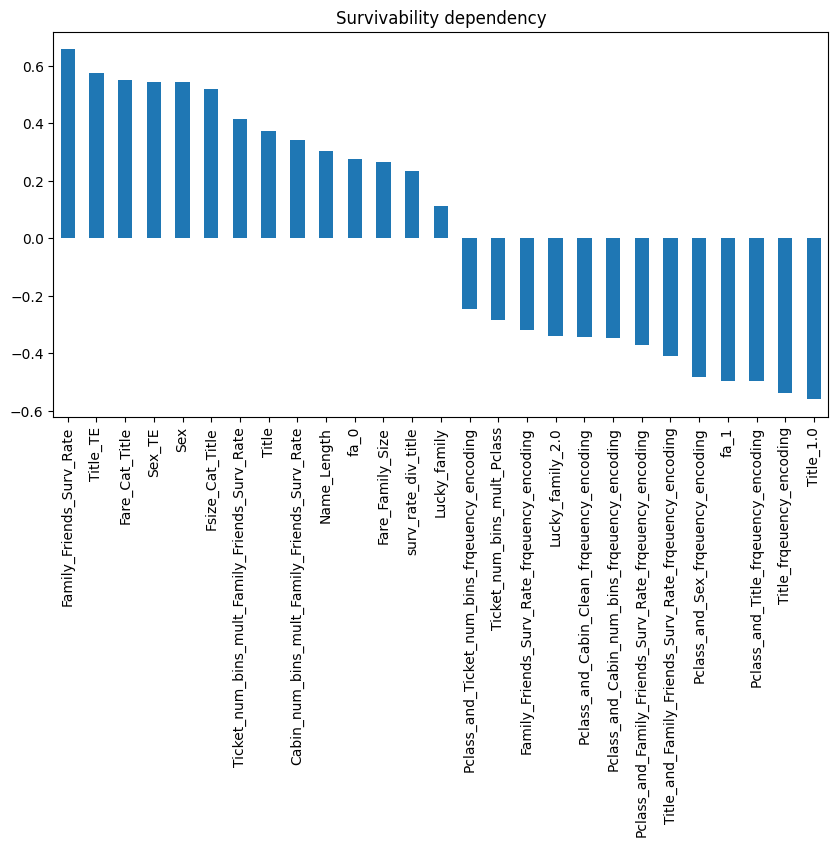

In [36]:
#Let's see the correlations with the target

correlation = X.corrwith(y).sort_values(ascending=False)

# Correlation graph
correlation[1:].plot(kind='bar', figsize=(10,5), title='Survivability dependency')
plt.show()

In [37]:
X.shape, y.shape

((1098, 28), (1098,))

# Deploy Keras Classifier

Note: the  NN was built and tuned using Keras Tuner - see the code below.

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import *
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [40]:
metrics = ['accuracy', 
           Precision(),
           Recall()]

In [41]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta = 0.0002, # minimium amount of change to count as an improvement
    patience  = 5,     # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [42]:
def create_model():
    model = Sequential()
    
    model.add(Input(shape=X.shape[1], name='Input_'))
    model.add(Dense(4096, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.1)))
    model.add(Dense(16, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.1)))
    model.add(Dense(8, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(0.1)))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))
    
    model.summary()
    optimize = Adam(lr = 0.0001)
    model.compile(optimizer = optimize, 
                       loss = 'binary_crossentropy', 
                       metrics = metrics)
    return model

In [43]:
%%capture

estimator = KerasClassifier(build_fn = create_model, 
                            epochs = 600, 
                            batch_size = 32, 
                            verbose = 1, 
                            validation_split=0.2,
                            callbacks=[early_stopping])

kfold = StratifiedKFold(n_splits = 3)
results = cross_val_score(estimator, X, y, cv = kfold)

In [47]:
%%capture

#Fit it on the whole dataset
train_history = estimator.fit(X, y, epochs = 600, batch_size = 32, validation_split=0.2)

In [48]:
print('Max Accuracy=', max(train_history.history['accuracy']))

Max Accuracy= 0.8542141318321228


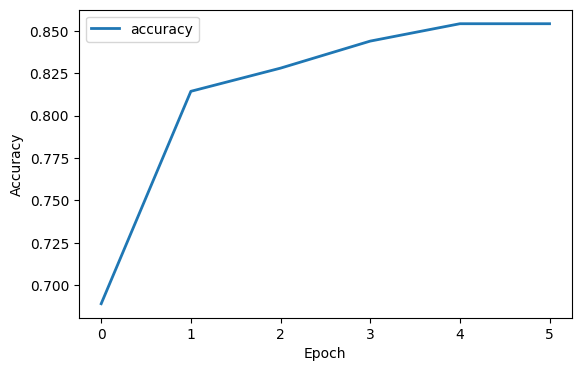

In [49]:
%matplotlib inline

logs = pd.DataFrame(train_history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs['accuracy'], lw=2, label='accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [51]:
#submission

y_preds = estimator.predict(test_df)

output = pd.DataFrame({'PassengerId': test.PassengerId,
                       'Survived': y_preds[:, 0]})

output.to_csv('submission.csv', index=False)

14/14 [==============================] - 0s 1ms/step


# Keras Tuner

In [56]:
import tensorflow as tf
from tensorflow import keras

In [57]:
%%capture
!pip install keras_tuner

In [58]:
import keras_tuner as kt

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [60]:
def model_builder(hp):
    
    model = keras.Sequential()
    model.add(Input(shape=X.shape[1], name='Input_'))

    hp_units1 = hp.Choice('units1', values=[16, 32, 64, 128, 256, 512, 1024, 2048, 4096])
    hp_units2 = hp.Choice('units2', values=[16, 32, 64, 128, 256, 512, 1024, 2048, 4096])
    hp_regulizer1 = hp.Choice('regulizer1', values=[0.0, 0.001, 0.01, 0.1])
    hp_regulizer2 = hp.Choice('regulizer2', values=[0.0, 0.001, 0.01, 0.1])
    hp_dropout1 = hp.Choice('dropout1', values=[0.0, 0.1, 0.3, 0.5])
    hp_dropout2 = hp.Choice('dropout2', values=[0.0, 0.1, 0.3, 0.5])

    model.add(keras.layers.Dense(units=hp_units1, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(hp_regulizer1)))
    model.add(Dropout(hp_dropout1))
    model.add(keras.layers.Dense(units=hp_units2, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer=l2(hp_regulizer2)))
    model.add(Dropout(hp_dropout2))

    
    model.add(Dense(8, activation='relu', kernel_initializer='normal', kernel_regularizer=l2(0.1)))
    model.add(Dense(1, activation='sigmoid'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])

    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='my_dir',
                     project_name='titanic_tune',
                     overwrite=True)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

tuner.search(X_train, y_train, 
             batch_size = 32, 
             epochs=50, 
             validation_split=0.2, 
             callbacks=[stop_early])


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.

Unit1
------
Neurons: {best_hps.get('units1')}
l2: {best_hps.get('regulizer1')}
Dropout: {best_hps.get('dropout1')}

Unit2
------
Neurons: {best_hps.get('units2')}
l2: {best_hps.get('regulizer2')}
Dropout: {best_hps.get('dropout2')}

Learning rate: {best_hps.get('learning_rate')}.

""")

# Unit3
# ------
# Neurons: {best_hps.get('units3')}
# l2: {best_hps.get('regulizer3')}
# Dropout: {best_hps.get('dropout3')}

Trial 90 Complete [00h 00m 02s]
val_accuracy: 0.5227272510528564

Best val_accuracy So Far: 0.9943181872367859
Total elapsed time: 00h 06m 06s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.

Unit1
------
Neurons: 256
l2: 0.0
Dropout: 0.0

Unit2
------
Neurons: 64
l2: 0.001
Dropout: 0.0

Learning rate: 0.01.




In [61]:
%%capture
# Build the model with the optimal hyperparameters and train it on the full train data for 100 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X, y, epochs=100, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1

In [62]:
print('Best epoch: %d' % (best_epoch,))

Best epoch: 17


In [63]:
%%capture
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X, y, epochs=best_epoch, validation_split=0.2)

In [64]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

7/7 [==============================] - 0s 2ms/step - loss: 0.1277 - accuracy: 0.9636
[test loss, test accuracy]: [0.12773045897483826, 0.9636363387107849]


In [65]:
hypermodel_preds = hypermodel.predict(test_df)

14/14 [==============================] - 0s 1ms/step


In [66]:
hypermodel_preds_clean = [1 if i>0.5 else 0 for i in hypermodel_preds]